<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water). 

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project). 

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [1]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [2]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [3]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [4]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [5]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task: 
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [6]:
for i in range(0, Nt-1):
    T[i+1] = (dt/C_s) * (F(t[i])-gamma*(T[i]-theta[i])) + T[i]
    theta[i+1] = (dt/C_d)* (gamma*(T[i]-theta[i])) + theta[i]

After you are finished, run the cell below to plot the results

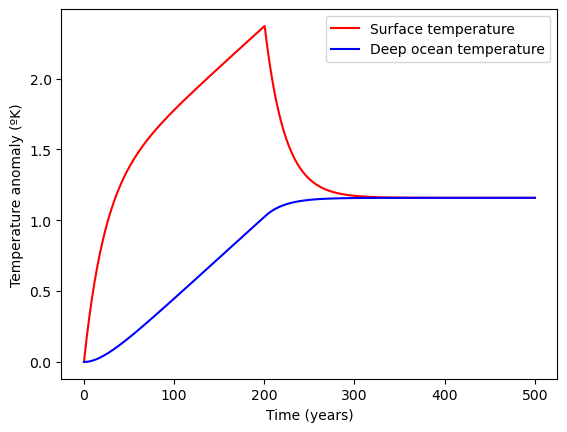

In [7]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain these rates by defining characteristic timescales from the box model equations?

Due to the presence of the forcing term at the start of the model run, the rate of change of temperature at the Earth's surface outpaces the rate of change of deep ocean temperature (the latter of which is zero at t=0 since the initial surface and ocean temperatures both equal 0). Thus, surface temperatures increase more rapidly. The surface temperature evolution reflects a timescale of $C_s / \gamma \simeq 25$ years, found by assuming $T$ is much larger than $\theta$ in the first box model equation, neglecting the forcing term, and solving to find $T= e^{-t\gamma/C_s}$.  As time progresses, the rate of change of ocean temperature increases as the difference between surface and deep ocean temperatures increase. This occurs on a timescale of $C_d / \gamma \simeq 232$ years, obtained by considering the characteristic timescale of the second box model equation in the absence of the surface temperature term (in which case the solution is $\theta = e^{-t\gamma/C_d}$). After about t=200, the absence of any forcing causes the rate of change of surface temperature to become negative since $T>\theta$, decreasing the temperature difference between surface and deep ocean. This behavior also contributes to a decreasing, yet still positive, rate of change of ocean temperature until the two quantities ultimately equilibriate. A timescale for this equilibriation can be estimated by subtracting the deep ocean box model equation from the surface equation, neglecting the forcing term, and replacing terms with characteristic scales t, T, $\theta$, $\gamma$, $C_s$, and $C_d$. This gives us $t\sim\gamma(1/C_s + 1/C_d)^{-1} \simeq 23$ years. This is nearly equivalent to the characteristic timescale for surface temperature adjustment, suggesting that the fast response time of surface temperatures to changes in the surface-deep ocean temperature differential allows for fairly quick equilibriation (although the plot appears to reach equilibrium over a slightly longer period, $\sim$ 50 years).

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

Scenario 1: Forcing takes the form of a logistic curve centered around t=200. Represents zero forcing -> rapid increase in forcing -> sustained high forcing.

In [8]:
def F2(t):
    # carrying capacity = 1, midpoint = 200 years, growth rate = 0.1 
    return 1/(1+np.exp(-0.1*(t-200)))

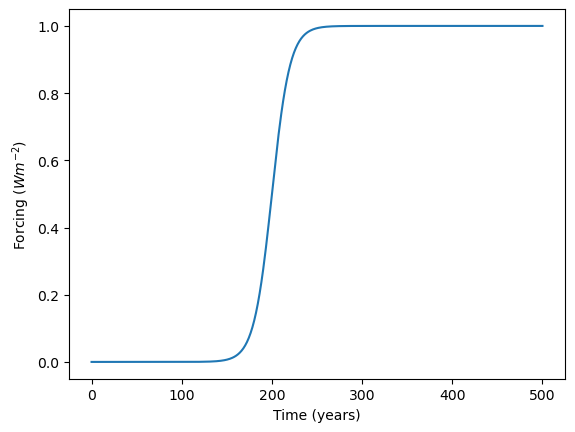

In [9]:
plt.plot(t, F2(t))
plt.xlabel("Time (years)")
plt.ylabel("Forcing ($Wm^{-2}$)")
plt.show()

In [10]:
T2 = np.zeros(Nt) # surface temperature array
theta2 = np.zeros(Nt) # deep ocean temperature array
T2[0] = 0 # initial surface temperature anomaly (ºK)
theta2[0] = 0 # initial deep ocean temperature anomaly (ºK)
for i in range(0, Nt-1):
    T2[i+1] = (dt/C_s) * (F2(t[i])-gamma*(T2[i]-theta2[i])) + T2[i]
    theta2[i+1] = (dt/C_d)* (gamma*(T2[i]-theta2[i])) + theta2[i]

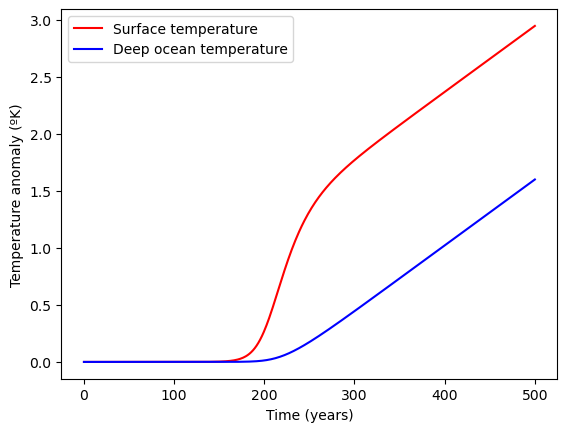

In [11]:
plt.plot(t,T2,'r-')
plt.plot(t,theta2,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

In this forcing scenario, the lack of forcing in the first ~150 years means that there is no difference in surface and deep ocean temperatures, leading to no anomalies in either quantity. When the forcing begins to increase around t=150, the surface temperatures increase rapidly while the deep ocean temperatures increase more slowly in response. Then, around t=275 (at which point the forcing has become constant), the slopes of the two anomaly curves become more or less parallel. At this point, the surface temperature anomalies are ~1-1.5 K higher than the deep ocean anomalies. When we are in the F(t) = 1 region, this behavior seems to be determined by the combination of constants used in our analysis: since $F/C_s = 1/17$, $\gamma/C_s(T-\theta) \simeq 0.039(T-\theta)$, and $\gamma / C_d (T-\theta)\simeq 0.0043(T-\theta)$, we can calculate that $\partial T / \partial t = \partial \theta / \partial t$ when $T-\theta\simeq 1.36 K$. Once this temperature differential is achieved within this regime, the two temperature quantities will then increase at the same rate indefinitely. 

Aside: changing the logistic growth rate (0.1 in my example) affects the number of years where the temperature differential is either nonzero or fixed. Smaller values (i.e., a wider logistic curve) increase the time spent in this transitionary period where the slopes are nonzero and nonconstant.

Scenario 2: Sinusoidal forcing, representing some sort of periodic forcing (e.g., changes in incoming solar radiation (although these would occur on much longer timescales in real life), periodic swings in anthropogenic emissions).

In [12]:
def F3(t):
    # Amplitude = 0.5, vertical offset of 0.5, period of 100 years
    return 0.5 + 0.5* np.sin(2 * np.pi * t / 100)

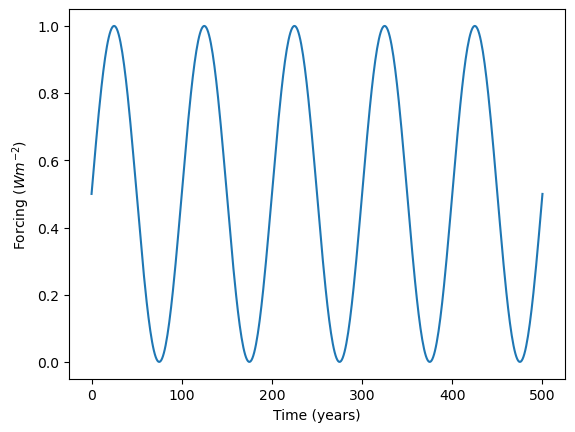

In [13]:
plt.plot(t, F3(t))
plt.xlabel("Time (years)")
plt.ylabel("Forcing ($Wm^{-2}$)")
plt.show()

In [14]:
T3 = np.zeros(Nt) # surface temperature array
theta3 = np.zeros(Nt) # deep ocean temperature array
T3[0] = 0 # initial surface temperature anoma"ly (ºK)
theta3[0] = 0 # initial deep ocean temperature anomaly (ºK)
for i in range(0, Nt-1):
    T3[i+1] = (dt/C_s) * (F3(t[i])-gamma*(T3[i]-theta3[i])) + T3[i]
    theta3[i+1] = (dt/C_d)* (gamma*(T3[i]-theta3[i])) + theta3[i]

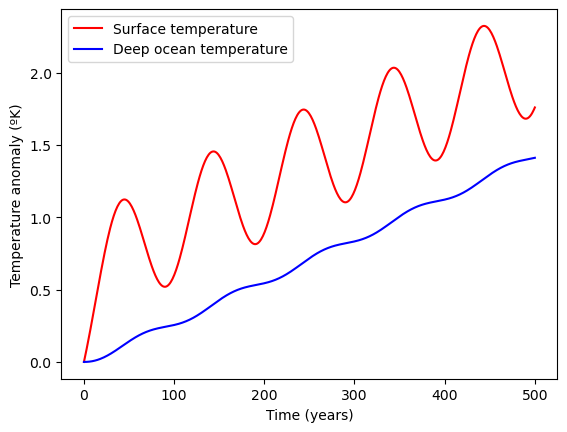

In [15]:
# Add code to make plots here
plt.plot(t,T3,'r-')
plt.plot(t,theta3,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

The presence of a sinusoidal forcing term clearly drives surface and deep ocean temperatures upwards at a similar, roughly constant rate. While both terms oscillate about this upward trend with a period roughly matching the period of the forcing term (100 years), the amplitude of these oscillations vary between the two terms. Surface temperatures swing by about 1.5 degrees, and deep ocean temperatures swing by about 0.1 degrees. This could possibly be explained by considering the characteristic timescales for our box model equations found above. Since the timescale for surface temperature adjustment is an order of magnitude shorter than the timescale for deep ocean temp. adjustment, surface temperatures are able to climb much more rapidly, increasing the relative ampltiude of the surface temp. oscillations. Also, note that oscillations in the deep ocean temperatures lag behind surface temperature oscillations by ~25 years. This can be understood using the second box model equation: when surface temperatures reach a local maximum, the difference between surface and deep ocean temps. is large. This means the rate of change of deep ocean temperatures also reaches a local max, driving up deep ocean temperatures. Then, as the forcing relaxes, surface temperatures drop, causing the slope of the deep ocean temperature curve to decrease before reaching a local maximum that lags slightly behind the previous surface temp. local max.

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [16]:
    def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [17]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0] 

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [18]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0] 

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)
    
    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [19]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [20]:
# Defining parameters
kappa = 0.01 # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100
t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [21]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.03 seconds


/home/hpihlaja/miniforge3/envs/LNM/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/hpihlaja/miniforge3/envs/LNM/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

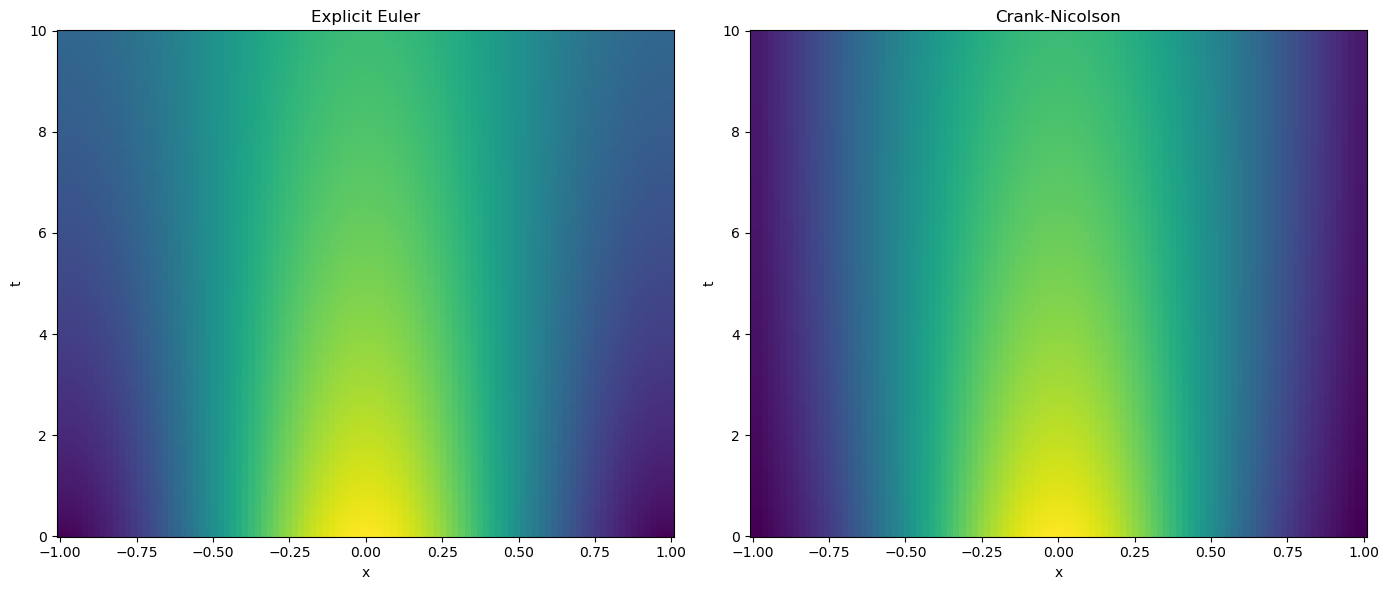

In [22]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

In [23]:
# Calculate solutions for varying values of kappa
kappas = [0.001, 0.01, 0.02, 0.021, 0.03, 0.04, 2, 10]
c_CNs = []
c_EEs = []
for kappa in kappas:
    c_EEs.append(EE(x, t, kappa)) # explicit Euler
    c_CNs.append(CN(x, t, kappa)) # Crank-Nicolson

Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds


/tmp/ipykernel_18590/1023445128.py:21: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


<>:7: SyntaxWarning: invalid escape sequence '\k'
<>:12: SyntaxWarning: invalid escape sequence '\k'
<>:7: SyntaxWarning: invalid escape sequence '\k'
<>:12: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_18590/3074415812.py:7: SyntaxWarning: invalid escape sequence '\k'
  axs[i, 0].set_title(f'Explicit Euler, $\kappa$ = {kappa}')
/tmp/ipykernel_18590/3074415812.py:12: SyntaxWarning: invalid escape sequence '\k'
  axs[i, 1].set_title(f'Crank-Nicolson,  $\kappa$ = {kappa}')
/home/hpihlaja/miniforge3/envs/LNM/lib/python3.13/site-packages/matplotlib/colors.py:2294: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
/home/hpihlaja/miniforge3/envs/LNM/lib/python3.13/site-packages/matplotlib/colors.py:2295: RuntimeWarning: overflow encountered in scalar subtract
  resdat /= (vmax - vmin)
/home/hpihlaja/miniforge3/envs/LNM/lib/python3.13/site-packages/matplotlib/colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


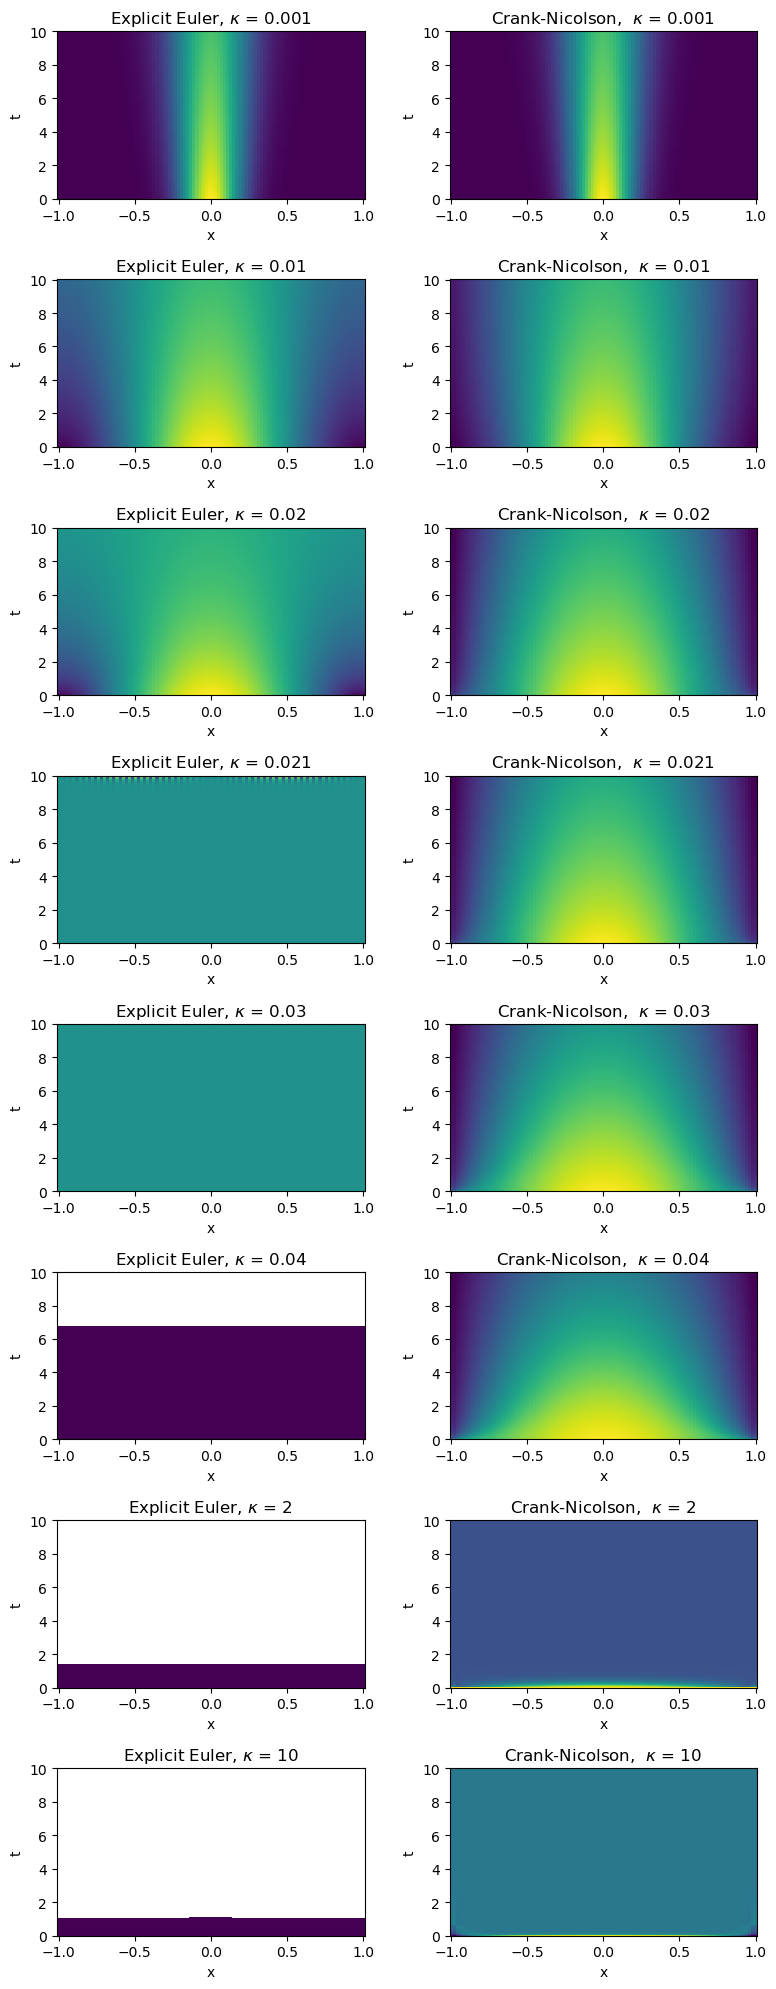

In [24]:
# Plot solutions for varying kappa
fig, axs = plt.subplots(len(kappas), 2, figsize=(8,20))
for i,kappa in enumerate(kappas):
    axs[i, 0].pcolormesh(x, t, c_EEs[i].T, shading='auto')
    axs[i, 0].set_xlabel('x')
    axs[i, 0].set_ylabel('t')
    axs[i, 0].set_title(f'Explicit Euler, $\kappa$ = {kappa}')

    axs[i, 1].pcolormesh(x, t, c_CNs[i].T, shading='auto')
    axs[i, 1].set_xlabel('x')
    axs[i, 1].set_ylabel('t')
    axs[i, 1].set_title(f'Crank-Nicolson,  $\kappa$ = {kappa}')


plt.tight_layout()
plt.show()

Qualitatively, this is very minimal difference between the solutions obtained for diffusivities below $\kappa= 0.01$. At 0.01, I was able to notice minimal differences between the EE and CN schemes at the boundaries. Between 0.02 and 0.021, the Explicit Euler scheme begins to break down, failing to produce any recognizable structure. The EE solution continues to break down above 0.03. However, the CN scheme appears to remain stable for much larger kappa, exhibiting reasonable behavior for values over 1, although the solutions do begin to break down at the boundaries for large kappa. Crank-Nicolson appears to be more stable than Explicit Euler for large kappa.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

In [25]:
# Function for the exact solution to the diffusion equation on an unbounded plane
def exact(x, t, kappa):
    return (4*np.pi*kappa*t)**(-0.5)*np.exp(-x**2 / (4*kappa*t))

In [26]:
# evaulate the exact solution at t=20 since c_EE(), c_CN()
# use the value of the exact solution at t=10 for the initial condition (tf = ti + 10)
kappa = 0.01
exact_sol = exact(x, 20, kappa)
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds


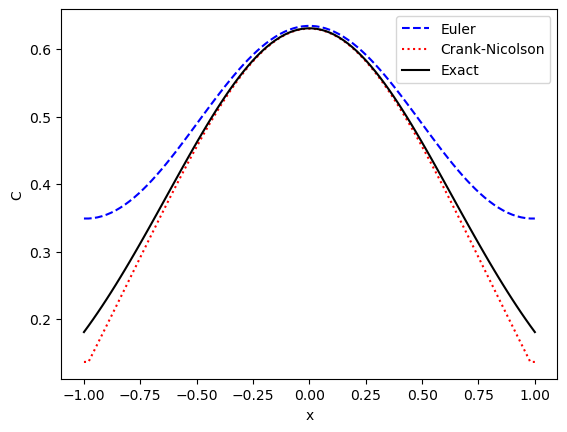

In [27]:
# Plotting for kappa = 0.01, t = 10
plt.plot(x, c_EE[:,-1], label="Euler", ls="--", c="b",)
plt.plot(x, c_CN[:,-1], label="Crank-Nicolson", ls="dotted", c="r",)
plt.plot(x, exact_sol, label="Exact", c="k")
plt.legend()
plt.xlabel("x")
plt.ylabel("C")
plt.show()

The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

In [28]:
# Change kappa to 0.001 to increase the chance that error is introduced at the boundaries
kappa = 0.001

The following figures will plot the absolute value of the global error at the point x=0 (chosen to be as far away from boundary-related error as possible) vs varying timestep sizes.

The key here is to limit the error in x in order to focus on behavior of the error in t. This will require adjusting the size of our spatial grid. As I will show below, we can safely decrease the size of our spatial grid for the Crank-Nicolson scheme, minimizing the error in x. Ideally, we would be able to use the same grid spacings for the Explicit Euler scheme. However, as our previous analysis suggests, the EE scheme is generally less stable than Crank-Nicolson. This limits our choices for $\Delta x$. Through trial and error, I found that using 101 grid points produces a nearly stable set of EE solutions for the same range of $\Delta t$ s used for my analysis of Crank-Nicolson's global error. This analysis should be taken with a grain of salt, though, as we can see a instability begin to grow within our plot of global error vs $\Delta t$ above ~$\Delta t = 0.3$. To use a higher resolution spatial grid, we would need to compensate by decreasing our timestep size substantially, thereby increasing the resources needed to compute solutions using the Explicit Euler scheme. 

(Alternatively, we could tweak $\kappa$ such that the EE scheme remains stable. However, decreasing it too much seems to lead to large errors at x=0 for the CN scheme... so we'll stick with things as they are for now.)

In [29]:
spacings = [int(n) for n in np.linspace(30,101, 100)]
ts = [np.linspace(0, 10, spacing) for spacing in spacings]
timesteps = []
errors_EE = []

#Define spatial grid for EE scheme
x_start = -1
x_end = 1

Nx = 101
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

#Indices for x=0
midpoint = int(Nx/2)

for t in ts:
    timesteps.append(t[1]-t[0])
    temp_EE = EE(x, t, kappa)
    temp_exact_EE = exact(x,20,kappa)
    errors_EE.append(abs(temp_exact_EE[midpoint] - temp_EE[midpoint,-1]))

Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds


In [30]:
spacings = [int(n) for n in np.linspace(30,101, 100)]
ts = [np.linspace(0, 10, spacing) for spacing in spacings]
timesteps = []
errors_CN = []

#Define high-resolution spatial grid for CN scheme
x_start = -1
x_end = 1

Nx = 2001
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

#Indices for x=0
midpoint = int(Nx/2)

for t in ts:
    timesteps.append(t[1]-t[0])
    temp_CN = CN(x, t, kappa)
    temp_exact_CN = exact(x,20,kappa)
    errors_CN.append(abs(temp_exact_CN[midpoint] - temp_CN[midpoint,-1]))

Crank-Nicolson method took 0.54 seconds
Crank-Nicolson method took 0.51 seconds
Crank-Nicolson method took 0.51 seconds
Crank-Nicolson method took 0.51 seconds
Crank-Nicolson method took 0.51 seconds
Crank-Nicolson method took 0.51 seconds
Crank-Nicolson method took 0.52 seconds
Crank-Nicolson method took 0.52 seconds
Crank-Nicolson method took 0.53 seconds
Crank-Nicolson method took 0.56 seconds
Crank-Nicolson method took 0.53 seconds
Crank-Nicolson method took 0.53 seconds
Crank-Nicolson method took 0.54 seconds
Crank-Nicolson method took 0.54 seconds
Crank-Nicolson method took 0.54 seconds
Crank-Nicolson method took 0.54 seconds
Crank-Nicolson method took 0.55 seconds
Crank-Nicolson method took 0.56 seconds
Crank-Nicolson method took 0.55 seconds
Crank-Nicolson method took 0.55 seconds
Crank-Nicolson method took 0.56 seconds
Crank-Nicolson method took 0.56 seconds
Crank-Nicolson method took 0.56 seconds
Crank-Nicolson method took 0.57 seconds
Crank-Nicolson method took 0.57 seconds


<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_18590/2134915752.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta t$ (s)")
/tmp/ipykernel_18590/2134915752.py:13: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta t$ (s)")


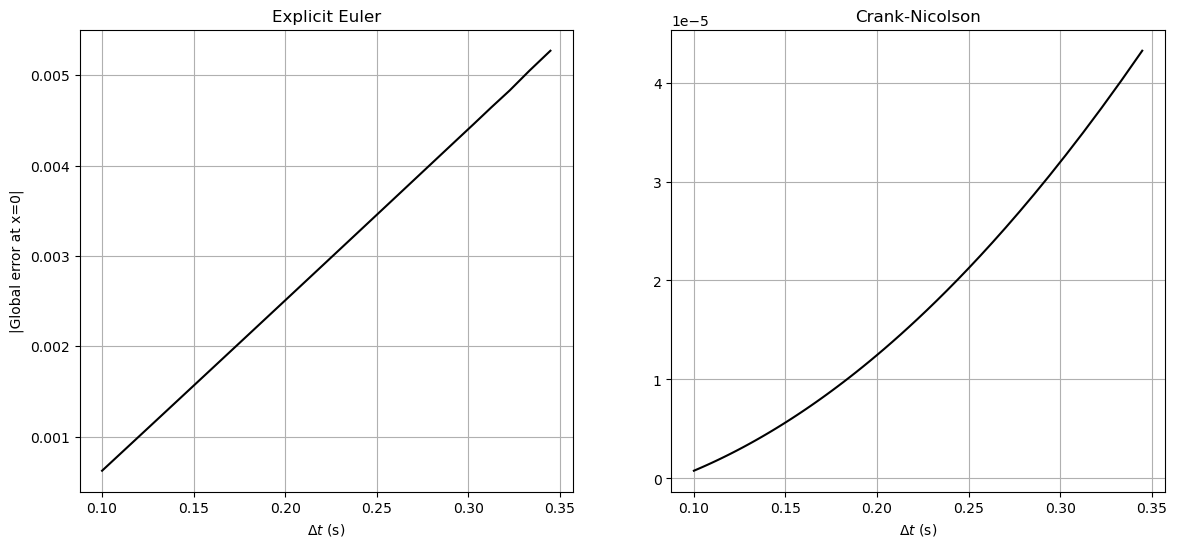

In [31]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(timesteps, errors_EE, color="k")
plt.title("Explicit Euler")
plt.xlabel("$\Delta t$ (s)")
plt.ylabel("|Global error at x=0|")
plt.grid()

plt.subplot(1,2,2)
plt.plot(timesteps, errors_CN, color="k")
plt.title("Crank-Nicolson")# evaulate the exact solution at t=20 since c_EE(), c_CN() use the value of the exact solution at t=10 for the initial condition
plt.xlabel("$\Delta t$ (s)")
plt.grid()

Keeping the difference in spatial grids in mind, these plots reveal that the EE scheme's global error increases linearly with timestep size, meaning this scheme is first order accurate. Meanwhile, the Crank-Nicolson scheme's error increases quadratically with timestep, meaning the CN scheme is second order accurate.

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

We will now use go back to using the same spatial grid (Nx=101) to more directly compare the computational efficiencies of the two algorithms. We will use a range of timesteps between 0.1 and 0.15 to compute our solutions. We will compare the amount of time taken to compute each solution using both schemes when the global error of the solution at x=0 is less than 0.0013.

In [32]:
spacings = [int(n) for n in np.linspace(65,100, 100)]
ts = [np.linspace(0, 10, spacing) for spacing in spacings]
errors_EE, errors_CN = [], []
timings_EE, timings_CN = [], []
timesteps = []

x_start = -1
x_end = 1
Nx = 101
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x
midpoint = int(Nx/2)
temp_exact = exact(x, 20, kappa)

for t in ts:
    timesteps.append(t[1]-t[0])
    to_average_EE, to_average_CN = [], []

    for i in range(10):
        start_time = time.time()
        temp_EE = EE(x, t, kappa)
        end_time = time.time()
        to_average_EE.append(end_time-start_time)

        start_time = time.time()
        temp_CN = CN(x, t, kappa)
        end_time = time.time()
        to_average_CN.append(end_time-start_time)
        if i == 0:
            errors_EE.append(abs(temp_exact[midpoint] - temp_EE[midpoint, -1]))
            errors_CN.append(abs(temp_exact[midpoint] - temp_CN[midpoint, -1]))
    
    timings_EE.append(np.mean(to_average_EE))
    timings_CN.append(np.mean(to_average_CN))
    
    

Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.00 seconds


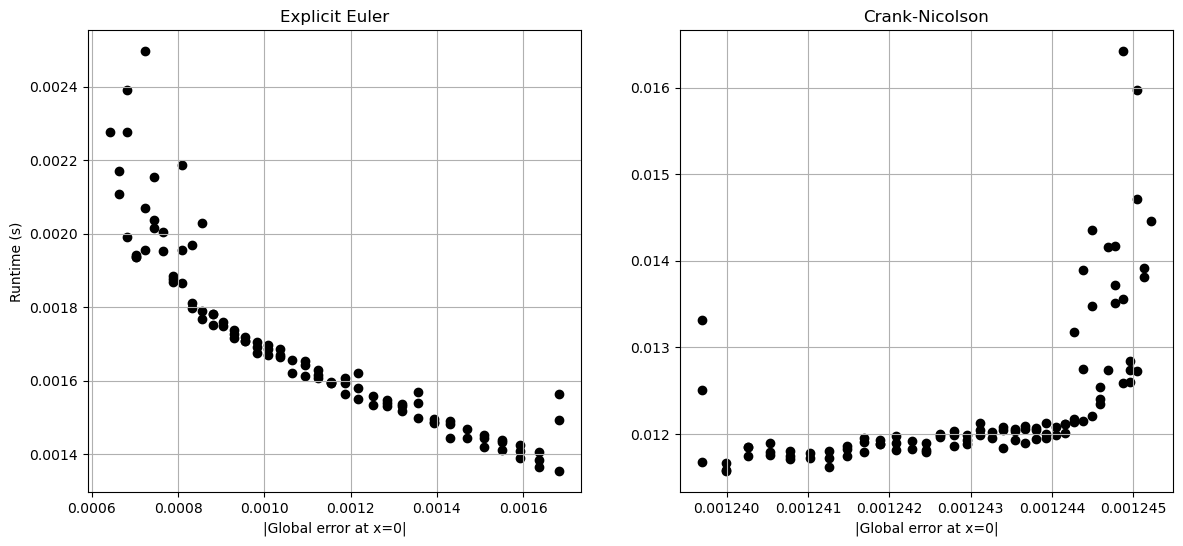

In [33]:
plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
plt.grid()
plt.scatter(errors_EE, timings_EE, c="k")
plt.title("Explicit Euler")
plt.xlabel("|Global error at x=0|")
plt.ylabel("Runtime (s)")

plt.subplot(1,2,2)
plt.grid()
plt.scatter(errors_CN, timings_CN, c="k")
plt.title("Crank-Nicolson")
plt.xlabel("|Global error at x=0|")


plt.show()

In [34]:
times_below_threshold = 0
times_faster = 0

for i,error in enumerate(errors_EE):
    if error < 0.0013:
        print(f"EE: timestep = {timesteps[i]}, error = {error}, runtime = {timings_EE[i]}")
        print(f"CN: timestep = {timesteps[i]}, error = {errors_CN[i]}, runtime = {timings_CN[i]}")

        if timings_EE[i] < timings_CN[i]:
            times_faster += 1

        times_below_threshold += 1
        print("---")

print("_______________")
print(f"For an error threshold of 0.0013, EE was faster than CN {times_faster}/{times_below_threshold} times.")




EE: timestep = 0.13513513513513514, error = 0.0012850926166037002, runtime = 0.0015378952026367187
CN: timestep = 0.13513513513513514, error = 0.001242085247662228, runtime = 0.011976408958435058
---
EE: timestep = 0.13513513513513514, error = 0.0012850926166037002, runtime = 0.0015322446823120117
CN: timestep = 0.13513513513513514, error = 0.001242085247662228, runtime = 0.011814308166503907
---
EE: timestep = 0.13513513513513514, error = 0.0012850926166037002, runtime = 0.0015464067459106446
CN: timestep = 0.13513513513513514, error = 0.001242085247662228, runtime = 0.011901283264160156
---
EE: timestep = 0.13333333333333333, error = 0.0012511729014572648, runtime = 0.001558971405029297
CN: timestep = 0.13333333333333333, error = 0.0012422728832821583, runtime = 0.011925482749938964
---
EE: timestep = 0.13333333333333333, error = 0.0012511729014572648, runtime = 0.0015347719192504883
CN: timestep = 0.13333333333333333, error = 0.0012422728832821583, runtime = 0.01183021068572998
---


These results confirm that the Explicit Euler scheme can be more efficient than CN for a global error bound of 0.0013. Below this error bound, runtime was nearly an order of magnitude lower for EE than for CN for every set of solutions tested. Thus, Explicit Euler provides a reasonable compromise between efficiency and accuracy for sufficiently large error bounds. Meanwhile, Crank-Nicolson is more computationally efficient, but it also produces solutions with consistently low global errors. This means CN may be favorable for problems where accuracy is valued over efficiency.

Aside: I noted an odd step function-style behavior in my runtime v. error plots. I'm not entirely sure why this occurs, but it may have to do with our choices of time and spatial grids, kappa, and/or the implementation of our algorithms in Python. (Regarding the latter, I received a "SparseEfficienyWarning" while computing solutions to the heat equation. This may have impacted runtime)

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

Homogeneous Neumann conditions require that $\partial C / \partial x$ = 0 at x=0 and x=L, where L is the extent of the spatial domain. If we approximate this derivative using a second-order accurate finite differences, we find that 

$\frac{\partial C}{\partial x} \simeq \frac{C(x+\delta x) - C(x-\delta x)}{2\delta x} = 0$
$\implies C(x+\delta x) = C(x-\delta x)$ 

at the boundaries of our spatial domain. Substituting this expression into out finite differences approximation of the second derivative, we find that 

$\frac{\partial^2C}{\partial x^2} \simeq \frac{2C(x+\delta x) - 2C(x)}{\delta x^2}  or \frac{2C(x-\delta x) - 2C(x)}{\delta x^2}$ (at the boundaries).

So, we can modify the first and last rows of our matrix to contain -2, 2, 0, 0.... and 0, ... 0, 2, -2, respectively. This makes intuitive sense, too, as we want the difference between the value of our function at the boundaries and at the neighboring points to be zero (zero gradient). Implementing this in our code:

In [35]:
def construct_M_modified(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M[0, 0] = -2 / dx**2
        M[0, 1] = 2 / dx**2
        M[-1, -1] = -2 / dx**2
        M[-1, -2] = 2 / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M

In [36]:
def CN_modified(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0] 

    M = construct_M_modified(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)
    
    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

In [37]:
c_CN_modified = CN_modified(x, t, 0.02)
c_CN = CN(x,t,0.02)

Crank-Nicolson method took 0.02 seconds
Crank-Nicolson method took 0.01 seconds


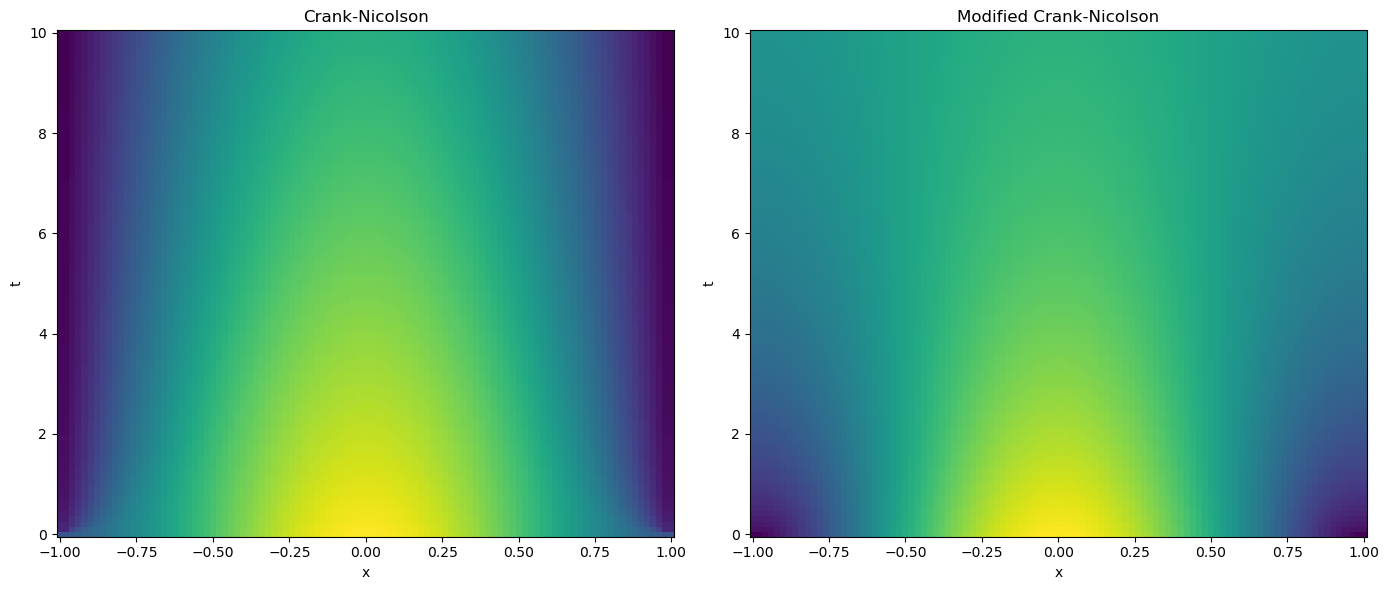

In [38]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN_modified.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Modified Crank-Nicolson')

plt.tight_layout()
plt.show()

In [39]:
# As a quick check, we use the numpy gradient function compute the derivatives in x
# of our orignal and modified CN schemes to validate that the boundary conditions are met.
modified_gradient = np.gradient(c_CN_modified)
original_gradient = np.gradient(c_CN)

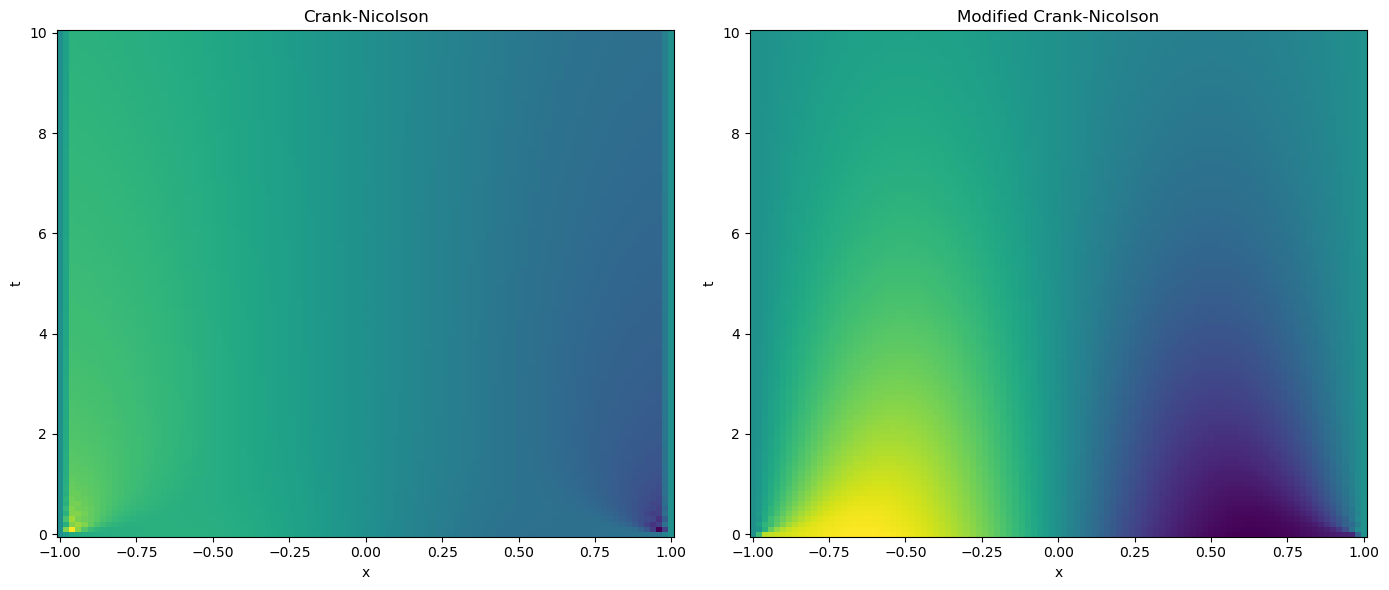

In [40]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, original_gradient[0].T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, modified_gradient[0].T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Modified Crank-Nicolson')

plt.tight_layout()
plt.show()

These plots validate that we have successfully modified the boundary conditions, and they show that the gradient is x is zero at the boundaries of our solution using the modified CN scheme. Also note that the gradient behaves much more smoothly for the modified scheme than for the original CN scheme, where the gradient appears to be pinned at zero only for points directly at the boundary.

We can use a similar approach to consider how arbitrary Neumann BCs may be implemented. Consider the case where the gradient of C is fixed at some f(x,t). Then, we have

$\frac{\partial C}{\partial x} \simeq \frac{C(x+\delta x) - C(x-\delta x)}{2\delta x} = f(x,t)$
$\implies C(x+\delta x) = C(x-\delta x) + 2\delta x f(x,t)$ 

Substituting in to our finite differences approximation of the second derviative at the boundaries, we see that

$\frac{\partial^2C}{\partial x^2} \simeq \frac{2C(x+\delta x) - 2C(x)}{\delta x^2} - \frac{2 f(0,t)}{\delta x}$ (at the leftmost boundary)

and 

$\frac{\partial^2C}{\partial x^2} \simeq \frac{2C(-\delta x) - 2C(x)}{\delta x^2} + \frac{2 f(L,t)}{\delta x}$ (at the rightmost boundary)

This suggests that we should be able to add some column vector b (containing the scaled boundary conditions in the first and last entries) to the matrix equation used to represent our second derivative, taking the form
$\frac{\partial^2C}{\partial x^2} \simeq Mc + b$,
where M is the modified matrix found in section 2.3, c is a column vector representing our function, and $b = \frac{2}{\delta x} [-f(0,t), 0, ..., 0, f(L,t)]^T$. We would then need to propagate this change through our Crank-Nicolson scheme and implement the updated alogrithm in code.

Meanwhile, implementing Dirichlet boundary conditions requires us to fix the value of our function at the boundaries such that $C(0,t) = \alpha(t)$ and $C(L,t) = \beta(t)$, where $\alpha, \beta$ are arbitrary functions of t. The simplest way I can think of implementing these boundary conditions is to prescribe the value of C at the boundaries for all t (e.g., setting c[0, :] = $\alpha$ and c[-1, ;] = $\beta$ within our CN function). Then, we could reduce the size of our coefficient matrix such that it is Nx-2 by Nx-2. This would ensure that our algorithm only affects interior points, not the prescribed points on the boundary. Then, we run the CN algorithm using a column vector containing only those interior points and enforce our boundary conditions accordingly to find our solution.